In [116]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
from numba import jit
from netCDF4 import Dataset


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

## towards a numba way of evaluating gamma distributions

need to evaluate alpha (shape), beta (scale), and fraction zero params

beta is a function of <x\> and alpha; alpha is function of ln(<x\>) and <ln(x)>, with <x\> for x>0


1. for a given month+bookends, read in 3 hourly MSWEP data.

Then, EITHER

2. at each grid point, sum precip values for all 3 hourly files --> break down by year (e.g., one intermediary file for each year)
    - check for small values (e.g., precip < .254 mm) & set to 0
    - record # of precip >0 days and precip = 0 days

3. compute D statistic --> alpha, beta, fraction 0

Gather all data belonging to chosen month, spanning the years 2002-2023. Data will be supplemented by "book-ending" months. So, for example, gathering data for the month of June will include May and July precip data as well. 

In [91]:
i=2007
month=2
chosen_date = datetime.datetime(year=i, month=2, day=1)

file_list=[]
#logic for determining prev/next months
if month == 1:
    prev_month = 12
    prev_year = i-1
    next_month = month+1
    next_year = i
elif month == 12:
    prev_month = month-1
    prev_year = i
    next_month = 1
    next_year = i+1
elif (month == 12) and (i == 2023):
    prev_month = month-1
    prev_year = i
    next_month = month
    next_year = i
elif (month == 1) and (i == 2002):
    prev_month = month
    prev_year = i
    next_month = month+1
    next_year = i
else:
    prev_month = month-1
    prev_year = i
    next_month = month+1
    next_year = i

#determine which days of year correspond to chosen month
date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
print(date_touples)
for datet in date_touples:
    m, y = datet[0], datet[1]
    dt = datetime.datetime(year=y, month=m, day=1)
    this_doy = dt.strftime('%Y%j')
    start = int(this_doy[4:])
    end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1 #how does datetime not have a # of days in month func??
    path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{y}/"
    expected_files = [path+f"{y}"+"{:03}.*.nc".format(j) for j in range(start, end+1)]
    for file_ in expected_files:
        file_list.append(sorted(glob(file_)))
#clean up nested list structure
mswep_paths = [
x
for xs in file_list
for x in xs
]



[(1, 2007), (2, 2007), (3, 2007)]


In [92]:
expected_files

['/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007060.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007061.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007062.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007063.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007064.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007065.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007066.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007067.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007068.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007069.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007070.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007071.*.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_int

In [94]:
mswep_paths

['/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.03.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.06.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.09.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.12.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.15.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.18.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007001.21.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007002.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007002.03.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007002.06.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2007/2007002.09.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/msw

In [68]:
ds = Dataset(mswep_files[0][0], mode='r')

In [54]:
#open first, get useful params
ds = Dataset(mswep_paths[0],mode="r")
nx = ds.dimensions['x'].size
ny = ds.dimensions['y'].size
#ds.close()

In [56]:
ds.variables['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(y, x)
    long_name: latitude
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (1597, 2345)
filling on, default _FillValue of 9.969209968386869e+36 used

In [57]:
multiprocessing.cpu_count()

80

In [5]:
#now open each chunk of mswep files to get 24 precip totals for some number of days
def open_and_sum(files):

    apcp_sums = np.zeros((ny,nx),dtype=np.float32)
    
    #sum to get 24 hour totals --> 8 files in a day
    for hour in range(8):
        f = files[hour]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums += apcp
    return apcp_sums

In [52]:
start = datetime.datetime.now()
with multiprocessing.Pool(4) as P:
    out = P.map(open_and_sum, mswep_files)
out = np.asarray(out)
end=datetime.datetime.now()

print(f"Finished in {(end-start).total_seconds()}")

Finished in 16.010125


In [111]:
@jit
def NUMBA_increment_gamma_components(apcp,thresh=0.0):
    y, x = np.shape(apcp)[1], np.shape(apcp)[2]

    npositive = np.zeros((ny,nx),dtype=np.int32)
    nzero = np.zeros((ny,nx),dtype=np.int32)
    xsum = np.zeros((ny,nx),dtype=np.float32)
    xsumln = np.zeros((ny,nx),dtype=np.float32)
    for day in range(np.shape(apcp)[0]):
        for dx in range(x):
            for dy in range(y):
                if (apcp[day, dy, dx] <= thresh) and (apcp[day, dy, dx] > 0.0):
                    nzero[dy, dx] += 1
                elif (apcp[day,dy, dx] > thresh) and (apcp[day,dy,dx] > 0.0):
                    npositive[dy, dx] += 1
                    xsum[dy, dx] += apcp[day,dy, dx]
                    xsumln[dy, dx] += np.log(apcp[day,dy, dx])
    return npositive, nzero, xsum, xsumln

In [53]:
ds.variables

RuntimeError: NetCDF: Not a valid ID

In [41]:
npositive,nzero,xsum,xsumln = NUMBA_increment_gamma_components(out,thresh=0.254)

In [59]:
ncoutput = f'/scratch2/STI/mdl-sti/Sidney.Lower/scripts/Supplemental_Locations/TEST2_{year[0]}{month:02d}_sums.nc'

ds = Dataset(mswep_paths[0],mode="r")

dsout = Dataset(ncoutput,mode="w",format="NETCDF4")
xdim = dsout.createDimension("x",nx)
ydim = dsout.createDimension("y",ny)
for name in ['latitude','longitude']:
    var = ds.variables[name]
    varout = dsout.createVariable(name,var.datatype,var.dimensions,
            zlib=True,complevel=4,chunksizes=tuple(var.chunking()))
    varout.setncatts(var.__dict__)
    varout[:,:] = var[:,:]
    ds.sync()
ds.close()

npos_var = dsout.createVariable("npositive","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
npos_var.long_name = "Number of Positive Precip Values"
npos_var.coordinates = "longitude latitude"

nzero_var = dsout.createVariable("nzero","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
nzero_var.long_name = "Number of Zero Precip Values"
nzero_var.coordinates = "longitude latitude"

xsum_var = dsout.createVariable("xsum","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
xsum_var.long_name = "Total Precip Values for Month"
xsum_var.coordinates = "longitude latitude"

xsumln_var = dsout.createVariable("xsumln","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
xsumln_var.long_name = "Total Log Precip Values for Month"
xsumln_var.coordinates = "longitude latitude"

npos_var[:,:] = npositive
nzero_var[:,:] = nzero
xsum_var[:,:] = xsum
xsumln_var[:,:] = xsumln
dsout.sync()
dsout.close()

In [63]:
a = xr.open_dataset('test_script.nc')

In [112]:
@jit
def compute_gamma_params(npos, nz, xsum, xsumln):
    DEFAULT_MISSING = -9999.
    
    alpha = np.zeros_like(npos,dtype=np.float32)
    beta = np.zeros_like(npos,dtype=np.float32)
    fz = np.zeros_like(npos,dtype=np.float32)
    ny, nx = np.shape(alpha)

    for i in range(ny):
        for j in range(nx):
            if npos[i,j] >= 1:
                average = xsum[i,j] / npos[i,j]
                average_of_log = (1.0 / npos[i,j]) * xsumln[i,j]
                dstat = np.log(average) - average_of_log
                alpha[i,j] = (1.0 + (np.sqrt(1.0 + ((4.0 * dstat) / 3.0)))) / (4.0 * dstat)
                if (alpha[i,j] <= 0.0) or (np.isfinite(alpha[i,j]) == False):
                    alpha[i,j] = DEFAULT_MISSING
                    beta[i,j] = DEFAULT_MISSING
                else:
                    beta[i,j] = average / alpha[i,j]
            else:
                alpha[i,j] = DEFAULT_MISSING
                beta[i,j] = DEFAULT_MISSING
            
            if ((nz[i,j] + npos[i,j]) <= 0):
                fz[i,j] = DEFAULT_MISSING
            else:
                fz[i,j] = (nz[i,j] / (nz[i,j] + npos[i,j]))
    return alpha, beta, fz


In [36]:
alpha,beta,fraczero = compute_gamma_params(npositive,nzero,xsum,xsumln)

array([[0.71003014, 0.7104892 , 0.71133506, ..., 0.8693883 , 0.8760702 ,
        0.87634575],
       [0.7152639 , 0.71399885, 0.71293586, ..., 0.8511288 , 0.8566775 ,
        0.87278104],
       [0.7100846 , 0.714375  , 0.71603686, ..., 0.8469973 , 0.84883744,
        0.86088705],
       ...,
       [0.95842385, 0.9616655 , 0.9615624 , ..., 0.9463532 , 0.9148127 ,
        0.90410596],
       [0.9396141 , 0.964346  , 0.9644742 , ..., 0.91462433, 0.9047663 ,
        0.8970055 ],
       [0.9418889 , 0.94310564, 0.94539225, ..., 0.916786  , 0.93026567,
        0.9294943 ]], dtype=float32)

In [137]:
ncoutput = '/scratch2/STI/mdl-sti/Sidney.Lower/scripts/Supplemental_Locations/test_out_gamma_params.nc'

ds = Dataset(mswep_paths[0],mode="r")

dsout = Dataset(ncoutput,mode="w",format="NETCDF4")
xdim = dsout.createDimension("x",nx)
ydim = dsout.createDimension("y",ny)
for name in ['latitude','longitude']:
    var = ds.variables[name]
    varout = dsout.createVariable(name,var.datatype,var.dimensions,
            zlib=True,complevel=4,chunksizes=tuple(var.chunking()))
    varout.setncatts(var.__dict__)
    varout[:,:] = var[:,:]
    ds.sync()

In [165]:
start = datetime.datetime.now()
ncoutput = '/scratch2/STI/mdl-sti/Sidney.Lower/scripts/Supplemental_Locations/test_out_gamma_params.nc'

ds = Dataset(mswep_paths[0],mode="r")

dsout = Dataset(ncoutput,mode="w",format="NETCDF4")
xdim = dsout.createDimension("x",nx)
ydim = dsout.createDimension("y",ny)
for name in ['latitude','longitude']:
    var = ds.variables[name]
    varout = dsout.createVariable(name,var.datatype,var.dimensions,
            zlib=True,complevel=4,chunksizes=tuple(var.chunking()))
    varout.setncatts(var.__dict__)
    varout[:,:] = var[:,:]
    ds.sync()
ds.close()

alpha_var = dsout.createVariable("alpha","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
alpha_var.long_name = "Gamma Alpha (Shape) Parameter"
alpha_var.missing_value = np.float32(DEFAULT_MISSING)
alpha_var.coordinates = "longitude latitude"

beta_var = dsout.createVariable("beta","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
beta_var.long_name = "Gamma Beta (Scale) Parameter"
beta_var.missing_value = np.float32(DEFAULT_MISSING)
beta_var.coordinates = "longitude latitude"

fz_var = dsout.createVariable("fraction_zero","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
fz_var.long_name = "Fraction Zero"
fz_var.missing_value = np.float32(DEFAULT_MISSING)
fz_var.coordinates = "longitude latitude"

alpha_var[:,:] = alpha
beta_var[:,:] = beta
fz_var[:,:] = fraczero
dsout.sync()
dsout.close()
finish = datetime.datetime.now()

print((finish-start).total_seconds())

1.809846


In [141]:
alpha_var[:,:] = alpha
beta_var[:,:] = beta
fz_var[:,:] = fraczero
dsout.sync()
dsout.close()

In [142]:
test = xr.open_dataset('test_out_gamma_params.nc')

In [143]:
test

<xarray.Dataset>
Dimensions:        (y: 1597, x: 2345)
Coordinates:
    latitude       (y, x) float32 ...
    longitude      (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    alpha          (y, x) float32 ...
    beta           (y, x) float32 ...
    fraction_zero  (y, x) float32 ...

In [150]:
test.alpha

<xarray.DataArray 'alpha' (y: 1597, x: 2345)>
array([[1.261217, 1.267261, 1.278418, ..., 0.897713, 0.898314, 0.896752],
       [1.235398, 1.247034, 1.260413, ..., 0.876558, 0.884563, 0.892839],
       [1.224576, 1.236481, 1.249356, ..., 0.865648, 0.869037, 0.871682],
       ...,
       [0.878192, 0.875371, 0.869708, ..., 0.98577 , 0.961719, 0.935745],
       [0.874393, 0.876587, 0.871343, ..., 0.94647 , 0.946971, 0.929048],
       [0.875789, 0.868093, 0.859583, ..., 0.946722, 0.940347, 0.92494 ]],
      dtype=float32)
Coordinates:
    latitude   (y, x) float32 19.23 19.23 19.24 19.24 ... 54.38 54.38 54.37
    longitude  (y, x) float32 233.7 233.7 233.8 233.8 ... 300.9 300.9 301.0
Dimensions without coordinates: y, x
Attributes:
    long_name:  Gamma Alpha (Shape) Parameter

In [154]:
g = np.ravel(test.alpha.data)

(array([0.000000e+00, 1.300000e+01, 6.434000e+04, 1.551403e+06,
        1.498310e+06, 3.024470e+05, 7.086600e+04, 2.799400e+04,
        1.942700e+04, 1.676000e+04, 1.445000e+04, 1.436600e+04,
        1.433700e+04, 1.437900e+04, 1.422600e+04, 1.229000e+04,
        1.041100e+04, 9.460000e+03, 9.204000e+03, 8.536000e+03,
        8.152000e+03, 8.142000e+03, 7.748000e+03, 6.728000e+03,
        5.155000e+03, 4.360000e+03, 3.792000e+03, 3.246000e+03,
        2.661000e+03, 2.669000e+03, 2.400000e+03, 1.937000e+03,
        1.697000e+03, 1.364000e+03, 1.214000e+03, 1.063000e+03,
        9.500000e+02, 7.930000e+02, 6.930000e+02, 5.640000e+02,
        5.150000e+02, 4.290000e+02, 3.770000e+02, 3.420000e+02,
        3.170000e+02, 2.750000e+02, 2.540000e+02, 2.510000e+02,
        2.000000e+02, 1.950000e+02]),
 array([ 0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ,  1.20000005,  1.39999998,  1.60000002,  1.79999995,
         2.        ,  2.20000005,  2.4000001 ,  

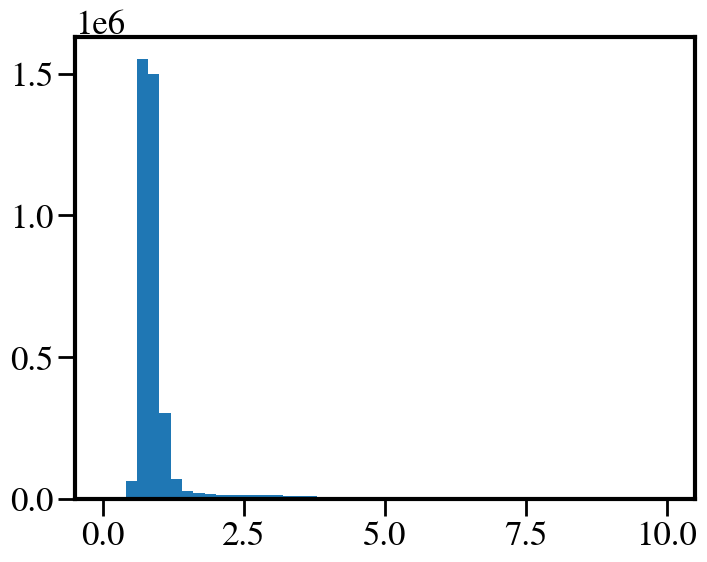

In [155]:
plt.hist(g, range=(0,10), bins=50)

{230.0: ([<matplotlib.lines.Line2D at 0x154c2d05b2b0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154c2d05b520>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154c2d05b7c0>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154c2d05ba60>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154c2d05bd00>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154c2d05bfa0>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154c2d098280>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154c2d098520>], [])}

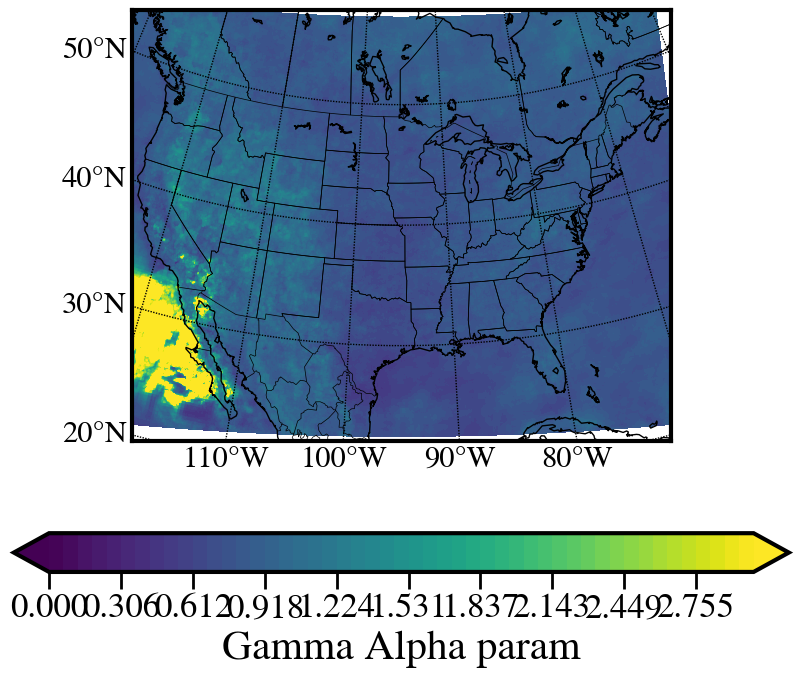

In [156]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_alpha = np.linspace(0,3,50)

#GEFS
lats, lons = test.latitude.data, test.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,test.alpha.data,extend='both',ax=axes,levels= clevs_alpha,cmap=cm.viridis)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Alpha param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [157]:
b = np.ravel(test.beta.data)

(array([2.11214e+05, 7.43430e+04, 6.01900e+04, 6.30740e+04, 7.68240e+04,
        1.10367e+05, 1.41335e+05, 1.65874e+05, 1.52000e+05, 1.41050e+05,
        1.65404e+05, 2.15161e+05, 2.32032e+05, 1.80049e+05, 1.69671e+05,
        1.68185e+05, 1.64249e+05, 1.52965e+05, 1.39626e+05, 1.32661e+05,
        1.20658e+05, 1.07490e+05, 9.74050e+04, 7.89190e+04, 6.38530e+04,
        5.49820e+04, 4.58290e+04, 3.96800e+04, 3.42910e+04, 2.85550e+04,
        2.52660e+04, 2.23500e+04, 2.02510e+04, 1.90440e+04, 1.66730e+04,
        1.36510e+04, 1.12850e+04, 8.48800e+03, 6.20000e+03, 3.71300e+03,
        2.80800e+03, 2.17300e+03, 1.63100e+03, 1.15800e+03, 7.78000e+02,
        4.85000e+02, 3.34000e+02, 2.02000e+02, 1.18000e+02, 1.12000e+02]),
 array([ 0.        ,  0.40000001,  0.80000001,  1.20000005,  1.60000002,
         2.        ,  2.4000001 ,  2.79999995,  3.20000005,  3.5999999 ,
         4.        ,  4.4000001 ,  4.80000019,  5.19999981,  5.5999999 ,
         6.        ,  6.4000001 ,  6.80000019,  7

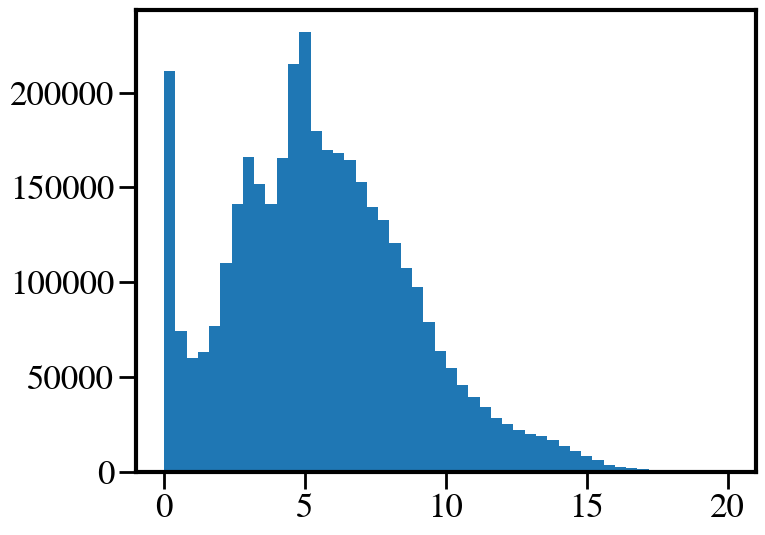

In [159]:
plt.hist(b, range=(0,20), bins=50)

{230.0: ([<matplotlib.lines.Line2D at 0x154d81313130>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154d813133a0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154d81313640>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154d813138e0>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154d81313b80>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154d81313e20>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154d81354100>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154d813543a0>], [])}

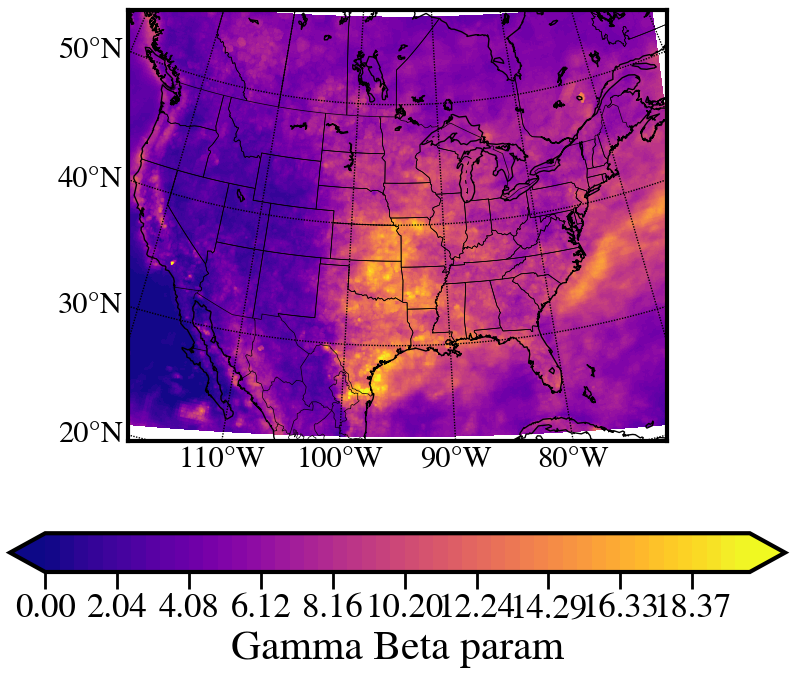

In [161]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_beta = np.linspace(0,20,50)

#GEFS
lats, lons = test.latitude.data, test.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,test.beta.data,extend='both',ax=axes,levels= clevs_beta,cmap=cm.plasma)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Beta param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

## testing MSWEP APCP values

In [79]:
test_paths = ['/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.03.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.06.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.09.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.12.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.15.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.18.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.21.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002122.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002122.03.nc']

In [80]:
ds = Dataset(test_paths[4], mode='r')

In [81]:
apcp_var = ds.variables['precipitation']
apcp = apcp_var[0,:,:]

In [82]:
np.where(apcp == 1.0)

(array([ 469,  572,  573,  596,  596,  596,  596,  597,  597,  597,  597,
         598,  598,  598,  599,  599,  599,  600,  617,  639,  639,  639,
         640,  640,  640,  640,  641,  641,  641,  641,  642,  642,  642,
         642,  643,  643,  643,  774,  775,  775,  775,  775,  775,  775,
         776,  776,  776,  776,  776,  776,  776,  777,  777,  777,  777,
         777,  777,  777,  778,  778,  778,  778,  778,  778,  778,  779,
         779,  779,  779,  779,  779,  779,  779,  780,  780,  780,  780,
         780,  780,  780,  781,  781,  781,  781,  781,  781,  781,  782,
         782,  782,  782,  782,  782,  782,  783,  783,  783,  783,  783,
         783,  783,  784,  784,  784,  784,  784,  784,  784,  784,  785,
         785,  785,  785,  785,  785,  785,  786,  786,  786,  786,  786,
         786,  786,  787,  787,  787,  787,  787,  787,  787,  788,  788,
         788,  788,  788,  788,  788,  789,  789,  789,  789,  789,  789,
         789,  789,  790,  790,  790, 

In [84]:
#if apcp = 1 at a grid point, then

npos = 1.
xsum = 1.
xsumln = np.log(xsum)

In [85]:
dstat = np.log(xsum / npos) - (1.0 / npos) * xsumln

In [86]:
dstat

0.0

In [89]:
#how many?

where_1 = len(np.where(np.ravel(apcp) == 1.0)[0])

frac = where_1 / (np.shape(apcp)[0] * np.shape(apcp)[1])

frac*100

0.011054842969159925

In [90]:
where_1

414

In [91]:
np.where(apcp < 0)

(array([], dtype=int64), array([], dtype=int64))

## the trials and tribulations of xarray x hera

In [8]:
from dask.distributed import Client

with Client(n_workers=8) as client:
    print(client)
    start = datetime.datetime.now()
    ds = xr.open_mfdataset(mswep_paths[:100], concat_dim='time',combine="nested", engine='h5netcdf', parallel=True) #will make a big ole dataset, aligning over 'time' dim
    finish = datetime.datetime.now()

    print(f'Finished loading in {(finish-start).total_seconds()}s')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37173 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45633' processes=8 threads=80, memory=152.34 GiB>
Finished loading in 26.265104s


In [ ]:
test = ds.resample('D').sum(dim='time')

In [95]:
num_pos = test.precipitation.where(.254<=test.precipitation)

In [78]:
mask_pos=daily['precipitation'].where(.254<=daily['precipitation'])
mask_zero = daily['precipitation'].where(0.0<=daily['precipitation']).where(.254>daily['precipitation'])

# Output

In [103]:
files = sorted(glob('/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/*/*06_precip_totals.nc'))
ds = xr.open_mfdataset(files, concat_dim=[pd.Index(np.arange(2002,2024), name="year")],combine="nested")

In [104]:
ds

<xarray.Dataset>
Dimensions:        (y: 1597, x: 2345, year: 22)
Coordinates:
    latitude       (y, x) float32 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude      (y, x) float32 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
  * year           (year) int64 2002 2003 2004 2005 2006 ... 2020 2021 2022 2023
Dimensions without coordinates: y, x
Data variables:
    npositive      (year, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    nzero          (year, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    nbelow_thresh  (year, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    xsum           (year, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    xsumln         (year, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>

In [110]:
npositive = ds.npositive.sum(dim='year').data.compute()
nzero = ds.nbelow_thresh.sum(dim='year').data.compute()
xsum = ds.xsum.sum(dim='year').data.compute()
xsumln = ds.xsumln.sum(dim='year').data.compute()

In [123]:
nzero_zero = ds.nzero.sum(dim='year').data.compute()

In [124]:
alpha,beta,fraczero_actual_zero = compute_gamma_params(npositive,nzero_zero,xsum,xsumln)

In [125]:
fraczero_actual_zero

array([[0.4302521 , 0.43097642, 0.4307305 , ..., 0.09310548, 0.08795749,
        0.08754407],
       [0.43240973, 0.4313233 , 0.43024227, ..., 0.08318584, 0.07796811,
        0.07824541],
       [0.4279767 , 0.42940685, 0.42976588, ..., 0.07857143, 0.07801419,
        0.07792208],
       ...,
       [0.10740291, 0.11891892, 0.11877625, ..., 0.2159161 , 0.21419829,
        0.2126367 ],
       [0.10656231, 0.11906194, 0.11884754, ..., 0.19190031, 0.19225967,
        0.19850653],
       [0.09063074, 0.10271903, 0.10234798, ..., 0.18842365, 0.1883792 ,
        0.19298245]], dtype=float32)

{230.0: ([<matplotlib.lines.Line2D at 0x14696da371f0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14696da37460>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14696da37700>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14696da379a0>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14696da37c40>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14696da37ee0>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14696da781c0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14696da78460>], [])}

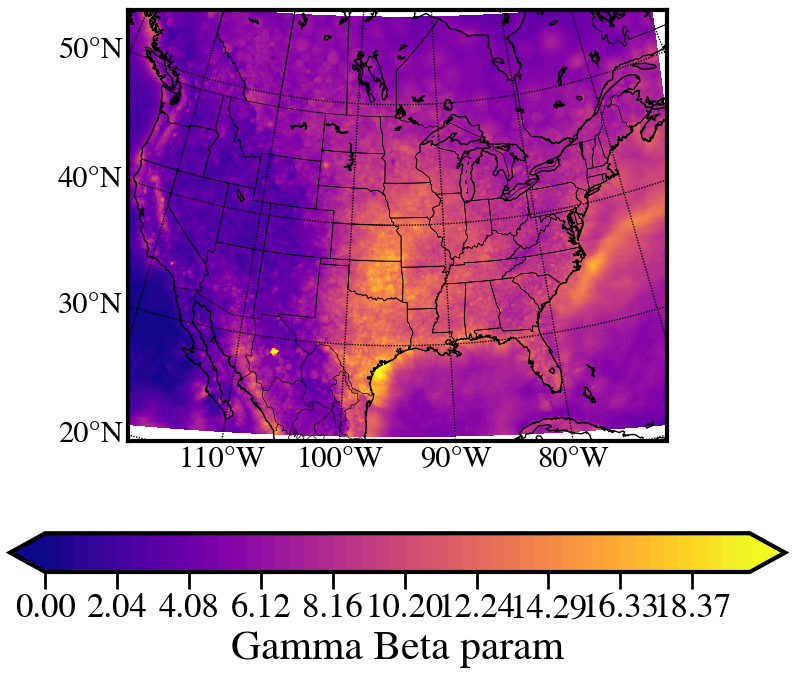

In [117]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_beta = np.linspace(0,20,50)

#GEFS
lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,beta,extend='both',ax=axes,levels= clevs_beta,cmap=cm.plasma)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Beta param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

{230.0: ([<matplotlib.lines.Line2D at 0x146965a2bb80>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x146965a2bdf0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x146965a680d0>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x146965a683a0>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x146965a68640>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x146965a688e0>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x146965a68b80>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x146965a68e20>], [])}

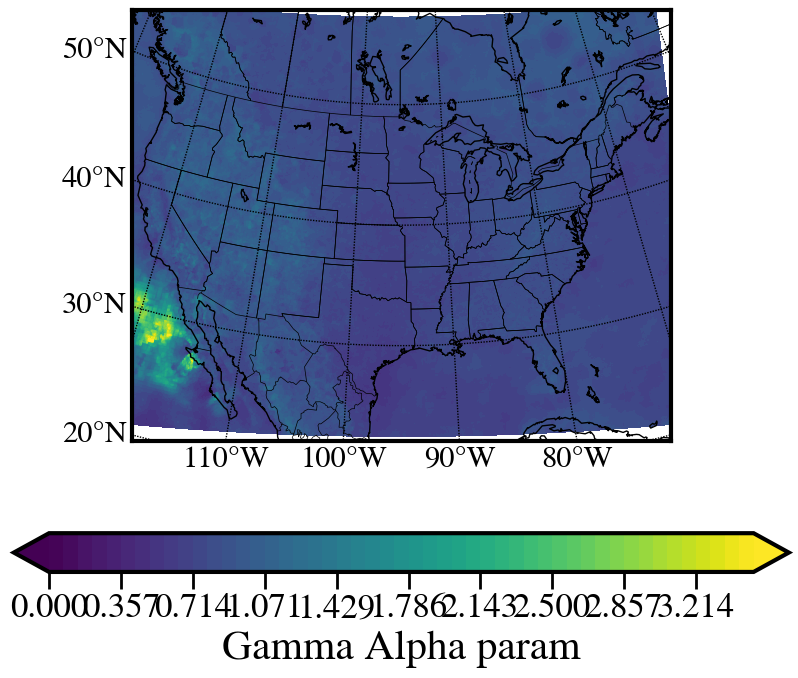

In [121]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_alpha = np.linspace(0,3.5,50)

#GEFS
lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,alpha,extend='both',ax=axes,levels= clevs_alpha,cmap=cm.viridis)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Alpha param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

(array([3.131067e+06, 4.691640e+05, 6.747700e+04, 3.814700e+04,
        2.355100e+04, 9.090000e+03, 4.109000e+03, 9.970000e+02,
        1.261000e+03, 1.020000e+02]),
 array([0.41476527, 0.9535467 , 1.49232805, 2.03110957, 2.56989098,
        3.10867238, 3.64745378, 4.18623495, 4.72501659, 5.26379776,
        5.8025794 ]),
 <BarContainer object of 10 artists>)

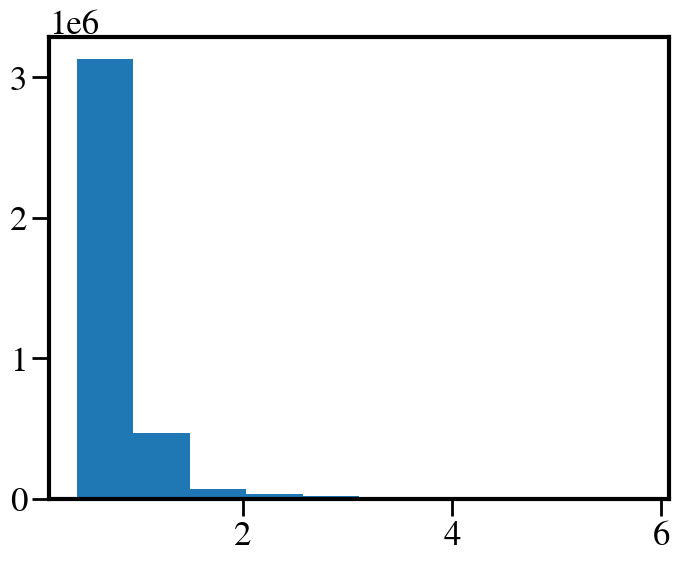

In [119]:
plt.hist(np.ravel(alpha))

In [122]:
fraczero

array([[0.5515873 , 0.55291003, 0.5512905 , ..., 0.17524116, 0.176     ,
        0.17173333],
       [0.5520212 , 0.55003315, 0.54804504, ..., 0.1747212 , 0.17494714,
        0.1781184 ],
       [0.5450331 , 0.5476821 , 0.5483444 , ..., 0.18181819, 0.17547569,
        0.1744186 ],
       ...,
       [0.20357336, 0.1966046 , 0.19550931, ..., 0.24074075, 0.23297492,
        0.22580644],
       [0.19653492, 0.19769989, 0.19605696, ..., 0.2441725 , 0.24592075,
        0.24457479],
       [0.20842217, 0.19902913, 0.19579288, ..., 0.23282887, 0.22668998,
        0.21759531]], dtype=float32)

In [127]:
dsout = xr.Dataset(
    data_vars=dict(
        alpha=(["y", "x"],alpha),
        beta=(["y", "x"], beta),
        frac_zero_thresh=(["y", "x"], fraczero),
        frac_zero=(["y", 'x'], fraczero_actual_zero)
    ),
    coords=dict(
        lon=(["y", "x"], lons),
        lat=(["y", "x"], lats),
    ),
    attrs=dict(years_summed="2002-2023", zero_threshold=".254"),
)

In [130]:
month_name = datetime.datetime(1, 6, 1).strftime("%B")
month_name

'June'

In [132]:
dsout.to_zarr(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/gamma_params/precip_climo_gamma_params_{month_name}.co.2p5.zarr')